### In this notebook, I will try to predict the telegrams' citation class labels based purely on doc2vec bodies representations using classical ML algorithm (LightGBM)

### For the Neural Network approach see: https://colab.research.google.com/drive/16oUZ8StACapm4mHRnWmb-GGrun3Kr2EX?usp=sharing

The problem is unbalanced, will use oversampling and class weights

In [151]:
import lightgbm as lgb
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer

In [152]:
import warnings
warnings.filterwarnings("ignore")

In [153]:
RS = 42

In [154]:
def get_report(y_true, y_pred):
    print("Test accuracy: ", balanced_accuracy_score(y_true, y_pred))
    print("Report: ")
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

In [155]:
def get_class_weights(target_labels, n_classes: int):
    total = len(target_labels)
    class_weights = {}
    for i in range(n_classes):
        class_i_cnt = len(np.where(target_labels==i)[0])
        class_weights[i] = (1 / class_i_cnt) * (total / n_classes)
    return class_weights

In [156]:
df_labels = pd.read_csv("../data/labels.csv", index_col=0)[['citation_class']]
df_doc_vec = pd.read_csv("doc_vectors.csv", index_col=0)
df = df_labels.join(df_doc_vec)

In [157]:
df

,citation_class,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
telegram_index,,,,,,,,,,,,,,,,,,,,,
3_atel,0,0.071868,-0.201624,0.271810,-0.027346,0.003459,-0.110452,-0.025864,-0.263887,0.206577,...,0.011202,-0.240187,0.078480,0.062145,0.063454,0.164338,0.146664,-0.192447,-0.208586,0.067344
2_atel,0,0.035786,-0.217161,0.282614,-0.033889,0.031198,-0.046244,-0.059987,-0.328853,0.239122,...,0.139342,-0.308597,0.063693,0.057740,0.121031,0.197053,0.044961,-0.165903,-0.115146,0.021687
4_atel,0,0.006793,-0.032616,0.075140,0.022439,0.020744,-0.061322,-0.183414,-0.094972,-0.037241,...,-0.043013,0.037575,0.002611,0.049404,-0.004333,0.127087,-0.182388,-0.061704,-0.121525,0.127395
5_atel,0,0.059242,-0.046478,0.014021,-0.004377,0.012646,0.059573,0.001543,-0.012033,-0.066125,...,-0.100126,0.050133,0.012575,0.122288,-0.076159,0.130226,-0.081526,-0.087177,-0.067171,0.134256
6_atel,0,0.061535,0.041484,0.156877,0.081235,0.027755,0.061770,-0.033926,-0.095284,0.004160,...,-0.097652,-0.170949,0.021982,0.089018,-0.137259,0.204253,-0.059254,0.035186,-0.212191,0.126887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16033_atel,0,-0.134906,-0.042763,0.117071,0.107838,0.154254,0.057849,-0.130010,-0.180962,-0.155351,...,-0.096712,-0.010427,0.036433,-0.107689,-0.104777,0.045682,-0.184436,-0.291302,-0.223877,0.116492
16034_atel,0,-0.232072,-0.048323,0.370639,0.093333,0.174632,0.103655,-0.195085,0.051462,-0.061205,...,-0.134886,-0.247225,-0.183990,0.009600,-0.115369,-0.053299,-0.091657,0.108027,-0.129829,0.142072
16035_atel,0,-0.109719,-0.080325,0.084469,0.070288,0.178452,0.094157,-0.094856,-0.190852,-0.139286,...,-0.095111,0.003520,-0.002844,-0.171705,-0.119383,0.038013,-0.231003,-0.288151,-0.205065,0.139147


In [158]:
df.citation_class.value_counts()

0    36746
1     9042
2     2491
Name: citation_class, dtype: int64

I'll remove the last 100 records from the data, as the latest telegrams might not had a chance to get cited, and might be missleading the model

In [159]:
df = df.iloc[:-100]

In [160]:
len(df)

48179

In [161]:
X, y = df.iloc[:, 1:].values, df.citation_class.values.reshape(-1, 1)

In [162]:
X.shape, y.shape

((48179, 256), (48179, 1))

#### random params performance check (always stratifying as the classes are very imbalanced)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)

In [79]:
gbm = lgb.LGBMClassifier(max_depth=4, n_estimators=150, learning_rate=0.1, reg_alpha=0.1, random_state=RS)
gbm.fit(X_train,y_train)

LGBMClassifier(max_depth=4, n_estimators=150, random_state=42, reg_alpha=0.1)

In [80]:
y_pred = gbm.predict(X_test)

In [81]:
print(f"Train accuracy: {balanced_accuracy_score(y_train, gbm.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.5853050826338905
Test accuracy:  0.5036772314247207
Report: 
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      5500
           1       0.58      0.25      0.35      1353
           2       0.55      0.29      0.38       374

    accuracy                           0.80      7227
   macro avg       0.65      0.50      0.54      7227
weighted avg       0.77      0.80      0.76      7227

Confusion matrix:
[[5320  156   24]
 [ 943  345   65]
 [ 170   96  108]]


#### add oversampling

In [163]:
ros = RandomOverSampler(random_state=RS)

In [164]:
X_train, y_train = ros.fit_resample(X_train, y_train)

In [165]:
gbm = lgb.LGBMClassifier(max_depth=4, n_estimators=150, learning_rate=0.1, reg_alpha=0.1, random_state=RS)
gbm.fit(X_train,y_train)

LGBMClassifier(max_depth=4, n_estimators=150, random_state=42, reg_alpha=0.1)

In [166]:
y_pred = gbm.predict(X_test)
y_pred_train = gbm.predict(X_train)
print(f"Train accuracy: {balanced_accuracy_score(y_train, y_pred_train)}")
get_report(y_test, y_pred)

Train accuracy: 0.7943230553683917
Test accuracy:  0.6532335405706998
Report: 
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      5500
           1       0.39      0.47      0.42      1353
           2       0.27      0.74      0.39       374

    accuracy                           0.70      7227
   macro avg       0.52      0.65      0.55      7227
weighted avg       0.78      0.70      0.73      7227

Confusion matrix:
[[4157  936  407]
 [ 364  634  355]
 [  33   66  275]]


In [167]:
# try binary
y_test[y_test>1] = 1
y_train[y_train>1] = 1
gbm = lgb.LGBMClassifier(max_depth=4, n_estimators=150, learning_rate=0.1, reg_alpha=0.1, random_state=RS)
gbm.fit(X_train,y_train)

LGBMClassifier(max_depth=4, n_estimators=150, random_state=42, reg_alpha=0.1)

In [168]:
y_pred = gbm.predict(X_test)
y_pred_train = gbm.predict(X_train)
print(f"Train accuracy: {balanced_accuracy_score(y_train, y_pred_train)}")
get_report(y_test, y_pred)

Train accuracy: 0.8269243109699361
Test accuracy:  0.757174869716271
Report: 
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      5500
           1       0.46      0.82      0.59      1727

    accuracy                           0.72      7227
   macro avg       0.69      0.76      0.69      7227
weighted avg       0.81      0.72      0.74      7227

Confusion matrix:
[[3813 1687]
 [ 309 1418]]


#### add class weights (thru params and manually)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)

In [87]:
gbm = lgb.LGBMClassifier(max_depth=4, n_estimators=150, learning_rate=0.1, reg_alpha=0.1, class_weight='balanced', random_state=RS)
gbm.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced', max_depth=4, n_estimators=150,
               random_state=42, reg_alpha=0.1)

In [88]:
y_pred = gbm.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, gbm.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.784702428931087
Test accuracy:  0.6510215208034433
Report: 
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      5500
           1       0.39      0.47      0.43      1353
           2       0.26      0.72      0.39       374

    accuracy                           0.70      7227
   macro avg       0.52      0.65      0.55      7227
weighted avg       0.78      0.70      0.73      7227

Confusion matrix:
[[4159  944  397]
 [ 359  639  355]
 [  33   70  271]]


In [89]:
# manually
class_weights = get_class_weights(y, 3)
class_weights

{0: 0.43798692739156914, 1: 1.780056159018695, 2: 6.449665327978581}

In [90]:
gbm = lgb.LGBMClassifier(max_depth=4, n_estimators=150, learning_rate=0.1, reg_alpha=0.1, class_weight=class_weights, random_state=RS)
gbm.fit(X_train,y_train)

LGBMClassifier(class_weight={0: 0.43798692739156914, 1: 1.780056159018695,
                             2: 6.449665327978581},
               max_depth=4, n_estimators=150, random_state=42, reg_alpha=0.1)

In [91]:
y_pred = gbm.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, gbm.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.7844613033443442
Test accuracy:  0.6510485341217048
Report: 
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      5500
           1       0.39      0.47      0.43      1353
           2       0.26      0.73      0.39       374

    accuracy                           0.70      7227
   macro avg       0.52      0.65      0.55      7227
weighted avg       0.78      0.70      0.73      7227

Confusion matrix:
[[4161  923  416]
 [ 368  635  350]
 [  36   66  272]]


#### class weights with oversampling

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)
X_train, y_train = ros.fit_resample(X_train, y_train)

gbm = lgb.LGBMClassifier(max_depth=4, n_estimators=150, learning_rate=0.1, reg_alpha=0.1, class_weight=class_weights, random_state=RS)
gbm.fit(X_train,y_train)

y_pred = gbm.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, gbm.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.706495117699276
Test accuracy:  0.6242032375403967
Report: 
              precision    recall  f1-score   support

           0       0.97      0.44      0.61      5500
           1       0.26      0.56      0.35      1353
           2       0.19      0.87      0.31       374

    accuracy                           0.49      7227
   macro avg       0.47      0.62      0.42      7227
weighted avg       0.80      0.49      0.54      7227

Confusion matrix:
[[2428 2168  904]
 [  71  757  525]
 [   5   43  326]]


### Proceed with the model tuning. Oversampling included

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RS)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [119]:
NFOLDS = 3
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RS)

In [120]:
scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)  

In [117]:
model = lgb.LGBMClassifier()

In [121]:
parameters = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [2, 4, 6],
    'reg_alpha': [0.1, 1],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [122]:
RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=3)

In [123]:
RSCV

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(), n_iter=333,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 4, 6],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'reg_alpha': [0.1, 1]},
                   scoring=make_scorer(balanced_accuracy_score), verbose=3)

In [124]:
RSCV.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=0.579 total time=   4.1s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=0.569 total time=   4.6s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=0.581 total time=   4.1s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=0.579 total time=   4.7s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=0.569 total time=   4.2s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=0.581 total time=   4.5s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=250, reg_alpha=0.1;, score=0.584 total time=   9.2s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=250, reg_alpha=0.1;, score=0.572 total time=   8.2s
[CV 3/3] END learning_rate=0.001, max_depth=2, n

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(), n_iter=333,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 4, 6],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'reg_alpha': [0.1, 1]},
                   scoring=make_scorer(balanced_accuracy_score), verbose=3)

In [125]:
best_estimator = RSCV.best_estimator_

In [126]:
y_pred = best_estimator.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, best_estimator.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.9995828921615811
Test accuracy:  0.5830201005753373
Report: 
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      5500
           1       0.49      0.42      0.45      1353
           2       0.53      0.42      0.47       374

    accuracy                           0.79      7227
   macro avg       0.63      0.58      0.60      7227
weighted avg       0.78      0.79      0.78      7227

Confusion matrix:
[[4998  452   50]
 [ 695  569   89]
 [  87  130  157]]


In [128]:
RSCV.best_params_  # that's a huge overfitting

{'reg_alpha': 0.1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.1}

In [149]:
gbm = lgb.LGBMClassifier(**{'reg_alpha': 1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.1, 'reg_lambda': 0.5})

In [142]:
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)
print(f"Train accuracy: {balanced_accuracy_score(y_train, gbm.predict(X_train))}")
get_report(y_test, y_pred)

Train accuracy: 0.9994973315793413
Test accuracy:  0.5874105763517529
Report: 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      5500
           1       0.50      0.42      0.46      1353
           2       0.52      0.43      0.47       374

    accuracy                           0.79      7227
   macro avg       0.63      0.59      0.61      7227
weighted avg       0.78      0.79      0.79      7227

Confusion matrix:
[[5006  440   54]
 [ 688  574   91]
 [  88  126  160]]


### Merge 1 and 2

In [139]:
y_pred_binary = (y_pred > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

In [140]:
get_report(y_test_binary, y_pred_binary)

Test accuracy:  0.7351876085697742
Report: 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      5500
           1       0.67      0.56      0.61      1727

    accuracy                           0.83      7227
   macro avg       0.77      0.74      0.75      7227
weighted avg       0.82      0.83      0.82      7227

Confusion matrix:
[[5017  483]
 [ 763  964]]


### check for the feature importances for the possible overfit reason

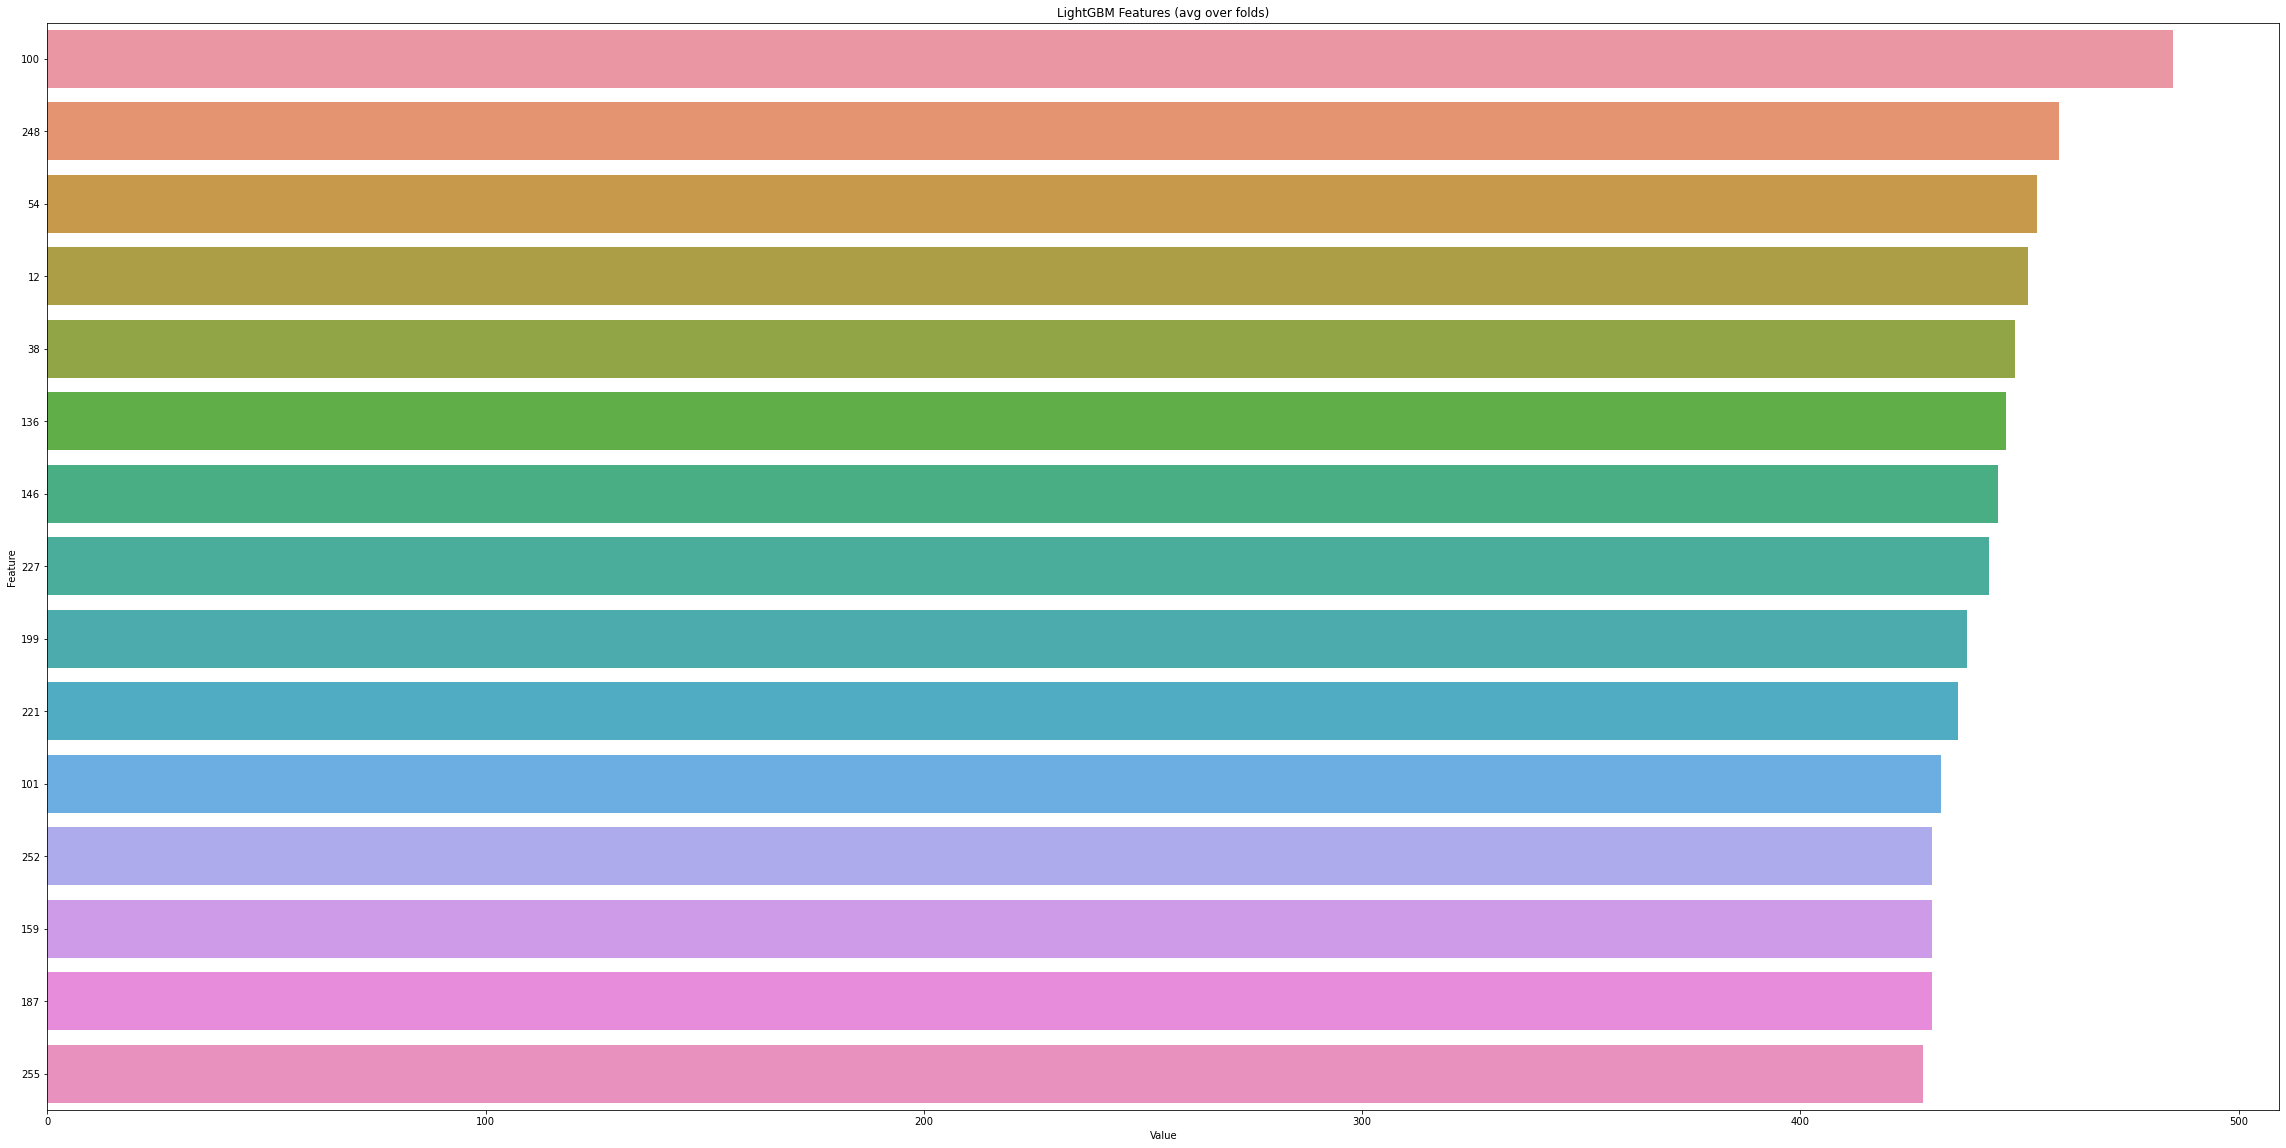

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = pd.DataFrame({'Value': gbm.feature_importances_, 'Feature': df.iloc[:, 1:].columns})

plt.figure(figsize=(40, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:15])
plt.title('LightGBM Features (avg over folds)')
plt.show()